In [ ]:
import sys, os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
from google.colab.patches import cv2_imshow
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from PIL import Image


In [ ]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def mse(img1, img2):
    err = np.sum((img1.astype("float") - img2.astype("float")) ** 2)
    err /= float(img1.shape[0] * img1.shape[1])
    return err

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DATA ACQUISITION

In [ ]:
import os
from pathlib import Path
folder_path_train = '/content/drive/My Drive/FSRCNN/Models'
Path(folder_path_train).mkdir(parents=True, exist_ok=True)

folder_path_train = '/content/drive/My Drive/FSRCNN/Train_Set'
Path(folder_path_train).mkdir(parents=True, exist_ok=True)

folder_path_lr = '/content/drive/My Drive/FSRCNN/Train_Set/Train_LR'
Path(folder_path_lr).mkdir(parents=True, exist_ok=True)

folder_path_hr = '/content/drive/My Drive/FSRCNN/Train_Set/Train_HR'
Path(folder_path_hr).mkdir(parents=True, exist_ok=True)

In [ ]:
import os
from pathlib import Path
folder_path_test = '/content/drive/My Drive/FSRCNN/Test_Set'
Path(folder_path_test).mkdir(parents=True, exist_ok=True)

folder_path_test_lr = '/content/drive/My Drive/FSRCNN/Test_Set/Test_LR'
Path(folder_path_test_lr).mkdir(parents=True, exist_ok=True)

folder_path_test_hr = '/content/drive/My Drive/FSRCNN/Test_Set/Test_HR'
Path(folder_path_test_hr).mkdir(parents=True, exist_ok=True)

In [ ]:
path = '/content/drive/MyDrive/FSRCNN/Train'

for file in os.listdir(path):
  image = cv2.imread(os.path.join(path, file))
  image = cv2.resize(image, (800, 800), interpolation=cv2.INTER_LINEAR)

  # Find old and new image dimensions
  h, w, c = image.shape
  new_height = int(h / 2)
  new_width = int(w / 2)

  # Resize down the image
  resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
  resized_image = cv2.resize(resized_image, (w, h), interpolation=cv2.INTER_LINEAR)

  # cv2_imshow(image)
  # print(image.shape)
  # cv2_imshow(resized_image)
  # print("PSNR:",psnr(image, resized_image))
  #image = cv2.resize(image, (h*2, w*2), interpolation=cv2.INTER_LINEAR)
  save_filename = os.path.join(folder_path_lr, file)
  cv2.imwrite(save_filename, resized_image)

  # save_filename1 = os.path.join(folder_path_hr, file)
  # cv2.imwrite(save_filename1, image)

In [ ]:
path = '/content/drive/MyDrive/FSRCNN/Test'

for file in os.listdir(path):
  image = cv2.imread(os.path.join(path, file))
  image = cv2.resize(image, (800, 800), interpolation=cv2.INTER_LINEAR)

  # Find old and new image dimensions
  h, w, c = image.shape
  new_height = int(h / 2)
  new_width = int(w / 2)

  # Resize down the image
  resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
  resized_image = cv2.resize(resized_image, (w, h), interpolation=cv2.INTER_LINEAR)

  # cv2_imshow(image)
  # print(image.shape)
  # cv2_imshow(resized_image)
  # print("PSNR:",psnr(image, resized_image))
  #image = cv2.resize(image, (h*2, w*2), interpolation=cv2.INTER_LINEAR)
  # save_filename = os.path.join(folder_path_test_lr, file)
  # cv2.imwrite(save_filename, resized_image)

  save_filename1 = os.path.join(folder_path_test_hr, file)
  cv2.imwrite(save_filename1, image)

# STATE OF THE ART MODEL

In [ ]:
import math
from torch import nn


class FSRCNN(nn.Module):
    def __init__(self, scale_factor, num_channels=3, d=56, s=12, m=4):
        super(FSRCNN, self).__init__()
        self.first_part = nn.Sequential(
            nn.Conv2d(num_channels, d, kernel_size=5, padding=5//2),
            nn.PReLU(d)
        )
        self.mid_part = [nn.Conv2d(d, s, kernel_size=1), nn.PReLU(s)]
        for _ in range(m):
            self.mid_part.extend([nn.Conv2d(s, s, kernel_size=3, padding=3//2), nn.PReLU(s)])
        self.mid_part.extend([nn.Conv2d(s, d, kernel_size=1), nn.PReLU(d)])
        self.mid_part = nn.Sequential(*self.mid_part)
        self.last_part = nn.ConvTranspose2d(d, num_channels, kernel_size=9, stride=scale_factor, padding=9//2,
                                            output_padding=scale_factor-1)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.first_part:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        for m in self.mid_part:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        nn.init.normal_(self.last_part.weight.data, mean=0.0, std=0.001)
        nn.init.zeros_(self.last_part.bias.data)

    def forward(self, x):
        x = self.first_part(x)
        x = self.mid_part(x)
        x = self.last_part(x)
        return x

# DATA ACQUISITION AND PROCESSING

In [ ]:
# Define your dataset class
class SuperResolutionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.dataset = ImageFolder(dataset_path)
        print(self.dataset.imgs)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        hr_image_path = None
        lr_image_path = None
        hr_image_path, _ = self.dataset.imgs[idx]
        print("hr path:",hr_image_path)
        hr_image = Image.open(hr_image_path).convert('RGB')

        lr_image_path = hr_image_path.replace('_HR', '_LR')
        print("lr path:",lr_image_path)
        lr_image = Image.open(lr_image_path).convert('RGB')

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        print("after lr:",lr_image.shape)
        print("after hr:",hr_image.shape)


        return lr_image, hr_image

In [ ]:
class SuperResolutionDataset(torch.utils.data.Dataset):
    def __init__(self, lr_path, hr_path, transform=None):
        self.lr_path = lr_path
        self.hr_path = hr_path
        self.transform = transform
        self.lr_images = os.listdir(lr_path)
        self.hr_images = [file.replace('_LR', '_HR') for file in self.lr_images]
        #print(self.hr_images)
    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image_file = self.lr_images[idx]
        hr_image_file = self.hr_images[idx]

        lr_image_path = os.path.join(self.lr_path, lr_image_file)
        hr_image_path = os.path.join(self.hr_path, hr_image_file)
        #print("hr path:",hr_image_path)
        #print("lr path:",lr_image_path)

        lr_image = Image.open(lr_image_path).convert('RGB')
        hr_image = Image.open(hr_image_path).convert('RGB')

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image


# MODEL TRAINING AND FINE TUNING

In [ ]:
from tqdm import tqdm
import torch
import torch.nn.functional as F

batch_size = 10
lr = 0.001
epochs = 25

# Initialize model, loss function, and optimizer
model = FSRCNN(2)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

# Load dataset and create DataLoader
train_dataset = SuperResolutionDataset('/content/drive/MyDrive/FSRCNN/Train_Set/Train_LR','/content/drive/MyDrive/FSRCNN/Train_Set/Train_HR', transform=ToTensor())
train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  pin_memory=True,
                                  drop_last=True)


for epoch in range(epochs):
    running_loss = 0.0

    for lr_images, hr_images in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):


        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(lr_images)
        #outputs = F.interpolate(outputs, size=(800, 800), mode='bilinear')
        print(outputs.shape)
        # Compute loss
        loss = criterion(outputs, hr_images)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/FSRCNN/Models/FSRCNN_weights.pth')

In [ ]:
model = FSRCNN(2)
model.load_state_dict(torch.load('/content/drive/MyDrive/FSRCNN/Models/FSRCNN_weights.pth'))

<All keys matched successfully>

In [ ]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# MODEL EVALUATION

In [ ]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
test_dataset = SuperResolutionDataset('/content/drive/MyDrive/FSRCNN/Test_Set/Test_LR','/content/drive/MyDrive/FSRCNN/Test_Set/Test_HR', transform=ToTensor())
test_loader = DataLoader(dataset=test_dataset,
                                  batch_size=3,
                                  shuffle=True,
                                  pin_memory=True,
                                  drop_last=True)
model.eval()
criterion = nn.MSELoss()
running_loss = 0.0
psnr_score_hr_lr = 0
psnr_score_loss = 0
total_images = 0
with torch.no_grad():

  for lr_images, hr_images in tqdm(test_loader, desc='Testing'):
        outputs = model(lr_images).clamp(0.0, 1.0)
        # Compute loss
        loss = criterion(outputs, hr_images)
        running_loss += loss.item()
        for i in range(3):
          hr_image = hr_images[i].numpy()
          hr_image = hr_image.transpose((1, 2, 0))
          lr_image = lr_images[i].numpy()
          lr_image = lr_image.transpose((1, 2, 0))
          lr_image = cv2.resize(lr_image, (800, 800), interpolation=cv2.INTER_LINEAR)

          lr_image = np.array(lr_image)
          output_image_np = outputs[i].squeeze().cpu().numpy().transpose((1, 2, 0))
          psnr_score_hr_lr = psnr(hr_image, lr_image)
          psnr_score_hr_gen = psnr(hr_image, output_image_np)
          psnr_score_loss += psnr_score_hr_gen - psnr_score_hr_lr
          total_images += 1


  print(f'Test Loss: {running_loss/len(test_loader)}')
  print(f'Average PSNR difference: {psnr_score_loss/total_images}')



In [ ]:
lr_image_path = '/content/drive/MyDrive/FSRCNN/Train_Set/Train_LR/Copy of t1.bmp'
lr_image = Image.open(lr_image_path)

# Display the image
plt.imshow(lr_image)
plt.axis('off')  # Hide axis
plt.show()

# INFERENCE, OPTIMIZATION AND REAL TIME TEST

In [ ]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
model = FSRCNN(2)
lr_image_path = '/content/drive/MyDrive/SRCNN/Train_Set/Train_LR/t11.bmp'
lr_image = Image.open(lr_image_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Add any other necessary preprocessing steps here
])

# Preprocess the image
input_tensor = transform(lr_image).unsqueeze(0)
print(input_tensor.shape)
traced_model = torch.jit.script(model, input_tensor)
traced_model.save("/content/drive/MyDrive/FSRCNN/Models/FSRCNN_weights_traced.pt")

In [ ]:
import time
lr_image_path = '/content/drive/MyDrive/FSRCNN/Train_Set/Train_LR/Copy of t11.bmp'
model  = FSRCNN(2)
loaded_model = torch.jit.load("/content/drive/MyDrive/FSRCNN/Models/FSRCNN_weights_traced.pt")
model.load_state_dict(torch.load('/content/drive/MyDrive/FSRCNN/Models/FSRCNN_weights.pth'))
loaded_model.load_state_dict(model.state_dict())
lr_image = Image.open(lr_image_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Add any other necessary preprocessing steps here
])

# Preprocess the image
overall = 0
for i in range(50):
  input_tensor = transform(lr_image).unsqueeze(0)
  start_time = time.time()

  with torch.no_grad():
      output = loaded_model(input_tensor)
  inference_time_raw = time.time() - start_time
  overall += inference_time_raw
print(overall/50)

In [ ]:
import time
lr_image_path = '/content/drive/MyDrive/SRCNN/Train_Set/Train_LR/t11.bmp'
model = FSRCNN(2)
model.load_state_dict(torch.load('/content/drive/MyDrive/FSRCNN/Models/FSRCNN_weights.pth'))
lr_image = Image.open(lr_image_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Add any other necessary preprocessing steps here
])

# Preprocess the image
overall = 0
for i in range(50):
  input_tensor = transform(lr_image).unsqueeze(0)
  start_time = time.time()

  with torch.no_grad():
      output = model(input_tensor)
  inference_time_raw = time.time() - start_time
  overall += inference_time_raw
print(overall/50)

In [ ]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Open the image
lr_image_path = '/content/drive/MyDrive/FSRCNN/Train_Set/Train_LR/butterfly_GT.bmp'
lr_image = Image.open(lr_image_path)

# Define a transform to preprocess the image
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Add any other necessary preprocessing steps here
])

# Preprocess the image
input_image = transform(lr_image).unsqueeze(0)  # Add a batch dimension

# Convert the tensor back to a numpy array and transpose dimensions
input_image_np = input_image.squeeze().cpu().numpy().transpose((1, 2, 0))
print(input_image_np.shape)

# Pass the input through the model and clamp the output
with torch.no_grad():
    preds = model(input_image).clamp(0.0, 1.0)

(800, 800, 3)


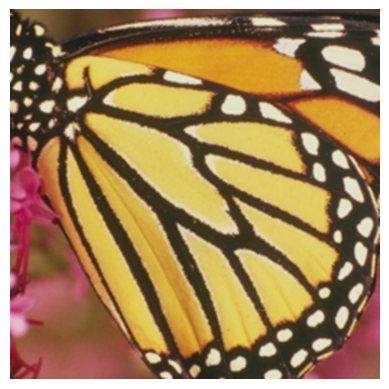

In [ ]:
plt.imshow(input_image_np)
plt.axis('off')  # Turn off axis
plt.show()

(1600, 1600, 3)


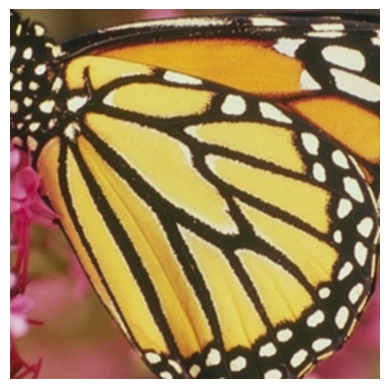

In [ ]:
#preds = F.interpolate(preds, size=(800, 800), mode='bicubic')
output_image_np = preds.squeeze().cpu().numpy().transpose((1, 2, 0))
print(output_image_np.shape)
plt.imshow(output_image_np)
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
print(input_image_np.shape)


In [ ]:
print(preds.shape)
import torch.nn.functional as F
#preds = F.interpolate(preds, size=(800, 800), mode='bicubic')
# output_image_np = preds.squeeze().cpu().numpy().transpose((1, 2, 0))
# print(output_image_np.shape)
# plt.imshow(output_image_np)
# plt.axis('off')  # Turn off axis
# plt.show()
input_image_np = cv2.resize(input_image_np, (800, 800), interpolation=cv2.INTER_LINEAR)
hr_image_cv = cv2.imread('/content/drive/MyDrive/FSRCNN/Train_Set/Train_HR/butterfly_GT.bmp')
hr_image_rgb = cv2.cvtColor(hr_image_cv, cv2.COLOR_BGR2RGB)
hr_image_rgb = hr_image_rgb.astype('float64')/255.0
print("Signal to noise ratio between generated image and HR image: " + str(psnr(hr_image_rgb, output_image_np)))
print("Signal to noise ratio between LR image and HR image: " +str(psnr(hr_image_rgb, input_image_np)))